# Smartwatch Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists on importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install tsfel >/dev/null 2>&1
from sys import platform
if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip >/dev/null 2>&1
else:
    !pip install wget >/dev/null 2>&1
    import wget
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip')

# Imports

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

In [2]:
# Import libraries
import glob
import tsfel
import secrets
import zipfile
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interpolate
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Unzip dataset
zip_ref = zipfile.ZipFile("wisdm-dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Auxiliary Methods

**Data pre-processing**

Method to interpolate accelerometer and gyroscope data to the same time interval.

In [3]:
def pre_process_data(data_acc, data_gyro, fs):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    data_gyro nd-array
    Gyroscope data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc[:, 2])/1e9 - data_acc[0, 2]/1e9
    data_act_acc = data_acc[:, 3:]

    time_gyro = (data_gyro[:, 2])/1e9 - data_gyro[0, 2]/1e9
    data_act_gyro = data_gyro[:, 3:]

    # time interval for interpolation
    t0 = np.max([time_acc[0], time_gyro[0]])
    tn = np.min([time_acc[-1], time_gyro[-1]])
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T
    gyro_data = np.array([interpolate.interp1d(time_gyro, data_act_gyro[:, ax])(time_new) for ax in range(np.shape(data_act_gyro)[1])]).T

    # concatenate interpolated data
    data = np.concatenate((acc_data, gyro_data), axis = 1)

    return data

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 51 subjects using a smartphone on their pocket and a smartwatch on their dominant hand. It contains a total of 18 activities whose labels are given by the following letters:

* Walking = A
* Jogging = B
* Stairs = C
* Sitting = D
* Standing = E
* Typing = F
* Brushing Teeth = G
* Eating Soup = H
* Eating Chips = I
* Eating Pasta = J
* Drinking from Cup = K
* Eating Sandwich = L
* Kicking Soccer Ball = M
* Playing Catch w/Tennis Ball = O
* Dribblinlg Basketball = P
* Writing = Q
* Clapping = R
* Folding Clothes = S

For this classification problem only the smartwatch data will be used.

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+).

# Load Data

Files from accelerometer and gyroscope of the smartwatch will be loaded.


In [4]:
# Loading smartwatch data files
watch_files_acc = np.sort(glob.glob('wisdm-dataset/raw/watch/accel' + "*/**.txt", recursive=True))
watch_files_gyro = np.sort(glob.glob('wisdm-dataset/raw/watch/gyro' + "*/**.txt", recursive=True))

# Defining train and test

Data will be splitted into equal sized windows according to the performed activity.

Train and Test sets will be defined.

In [5]:
all_acc_data = [np.array(pd.read_csv(acc_file, header = None, delimiter = ',', comment=';')) for acc_file in watch_files_acc]
all_gyro_data = [np.array(pd.read_csv(gyro_file, header = None, delimiter = ',', comment=';')) for gyro_file in watch_files_gyro]

x_test = []
x_train = []
y_test = []
y_train = []
activities = np.unique(np.vstack(all_acc_data)[:,1]).astype(str)
ntrain = 45
fs = 20 # According to dataset information
overlap = 0
ws = 200 # 10 second windows

for acq, (acc_data, gyro_data) in enumerate(zip(all_acc_data, all_gyro_data)):

    windows = []
    labels = []

    for act in activities:
        act_acc, act_gyro = np.where(acc_data == act)[0], np.where(gyro_data == act)[0]
        acc_data_act, gyro_data_act = acc_data[act_acc, :], gyro_data[act_gyro, :]
        ids_act_acc = np.append(0, np.where(np.diff(act_acc)>1)[0]+1)
        ids_act_gyro = np.append(0, np.where(np.diff(act_gyro)>1)[0]+1)

        if len(act_acc) == 0 or len(act_gyro) == 0:
            continue

        # Only one acquisition of act
        if (len(ids_act_gyro) == 1) and (len(ids_act_acc) == 1):
            data = pre_process_data(acc_data_act, gyro_data_act, fs)
            w = tsfel.signal_window_splitter(data.astype(float), ws, overlap) 
            windows.append(w)
            labels.append(np.repeat(act, len(w)))
        else:
            # More than one acquisition of act
            acc_data_acts = [acc_data_act[ids_act_acc[i]:ids_act_acc[i+1], :] for i in range(len(ids_act_acc)-1)]
            gyro_data_acts = [gyro_data_act[ids_act_gyro[i]:ids_act_gyro[i+1], :] for i in range(len(ids_act_gyro)-1)]

            for acc_data_act, gyro_data_act in zip(acc_data_acts, gyro_data_acts):
                data = pre_process_data(acc_data_act, gyro_data_act, fs)
                w = tsfel.signal_window_splitter(data.astype(float), ws, overlap)   
                windows.append(w)
                labels.append(np.repeat(act, len(w)))

    # Consider ntrain acquisitions for train and the remaining for test
    if acq<=ntrain:
        x_train.append(windows)
        y_train.append(np.hstack(labels))
    else:
        x_test.append(windows)
        y_test.append(np.hstack(labels))


In [6]:
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)
x_train = list(itertools.chain(*list(itertools.chain(*x_train))))
x_test = list(itertools.chain(*list(itertools.chain(*x_test))))

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics.

In this classification problem only features from the temporal domain will be used as input to the machine learning classifier.


In [7]:
cfg_file = tsfel.get_features_by_domain('temporal')
x_train_feat = tsfel.time_series_features_extractor(cfg_file, x_train, fs = fs, header_names = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz'])
x_test_feat = tsfel.time_series_features_extractor(cfg_file, x_test, fs = fs, header_names = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz'])

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [10]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(x_train_feat)
x_train_feat.drop(corr_features, axis=1, inplace=True)
x_test_feat.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(x_train_feat)
X_test = selector.transform(x_test_feat)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [11]:
classifier = RandomForestClassifier(n_estimators = 20, min_samples_split=10)

activities = ['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing', 
              'brushing teeth', 'eating soup', 'eating chips', 'eating pasta', 
              'drinking', 'eating sandwich', 'kicking', 'playing catch', 
              'dribblinlg', 'writing', 'clapping', 'folding clothes']

# Train The Classifier
classifier.fit(X_train, y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test)

# Get the Classification Report
accuracy = accuracy_score(y_test, y_predict)*100
print(classification_report(y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')

                 precision    recall  f1-score   support

        walking       0.84      0.60      0.70        85
        jogging       1.00      0.93      0.96        85
         stairs       0.71      0.71      0.71        85
        sitting       0.63      0.58      0.60        85
       standing       0.58      0.84      0.69        85
         typing       0.84      0.95      0.90        85
 brushing teeth       0.86      0.87      0.87        85
    eating soup       0.67      0.44      0.53        85
   eating chips       0.40      0.52      0.45        85
   eating pasta       0.72      0.65      0.68        85
       drinking       0.63      0.55      0.59        85
eating sandwich       0.29      0.24      0.26        85
        kicking       0.71      0.71      0.71       103
  playing catch       0.79      0.92      0.85        85
     dribblinlg       0.93      0.95      0.94        85
        writing       0.95      0.93      0.94        85
       clapping       0.87    

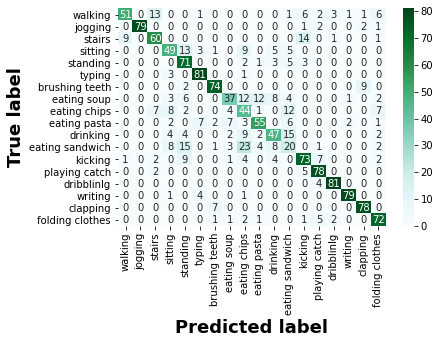

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()

# Conclusion

The final accuracy obtained by feeding a Random Forest classifier with only temporal domain features is around 75%.   

As it can be seen in the confusion matrix, eating chips activity is the class with more misclassified samples. This activity is being mainly classified as eating sandwich activity, which is reasonable since both activities rely almost on the same hand movement.

Although the overall results are satisfying, the increase of the classifier performance may be achieved by extracting features from all domains (temporal, statistical and spectral) and by including smartphone's data.